In [4]:
import pandas as pd
# import seaborn as sns
import numpy as np

# sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.read_table('../data/data.tsv')

df.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044


In [5]:
# df.info()

В наборе отсутствуют пустые значения, что не может не радовать. Все столбцы имеют численный формат.

Вычислим сколько времени проходит между показами одному пользователю (столбец duration), а также поставим флаг 1, когда после показа рекламы, пользователь кликнул на нее (столбец flg).

In [25]:
df_sort = df.sort_values(by=['user', 't'], ascending=True, axis=0)
df_sort['duration'] = df_sort.groupby(by=['user'], as_index=False)['t'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).values
df_sort['flg'] = df_sort.groupby(by=['user'], as_index=False)['tn'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] == 1 and x.iloc[0] == 0 else 0).values
df_sort.fillna(value=0, inplace=True)
df_sort[['user', 't', 'duration', 'tn', 'flg']].head(20)

,user,t,duration,tn,flg
0,21,1050848,0.0,0,0.0
3,36,694596,0.0,0,0.0
1,36,694606,10.0,0,0.0
4,36,694608,2.0,0,0.0
2,36,694659,51.0,0,0.0
5,121,256452,0.0,0,0.0
6,137,585721,0.0,0,0.0
7,148,463717,0.0,0,0.0
8,148,515262,51545.0,0,0.0
9,162,16301,0.0,0,0.0


In [26]:
df_sort.brotype.value_counts()

2     44830
9      2287
3       881
1       474
11      129
5        34
4        30
7         4
10        3
Name: brotype, dtype: int64

Большая часть запросов пришли с 2 типа браузера

In [27]:
df_user_click = df_sort[df_sort['flg'] == 1]
mean_val = df_user_click['duration'].mean()
median_val = df_user_click['duration'].median()

print(f'Среднее время, требующееся на клик: {mean_val}\nМедианное время, требующееся на клик: {median_val}')

n_init = df_user_click.shape[0]

Среднее время, требующееся на клик: 789.2948128693369
Медианное время, требующееся на клик: 7.0


Медианное и среднее значения очень сильно отличаются друг от друга. В данных присутствуют выбросы. Посмотрим на распределение времени, потребующееся на клик

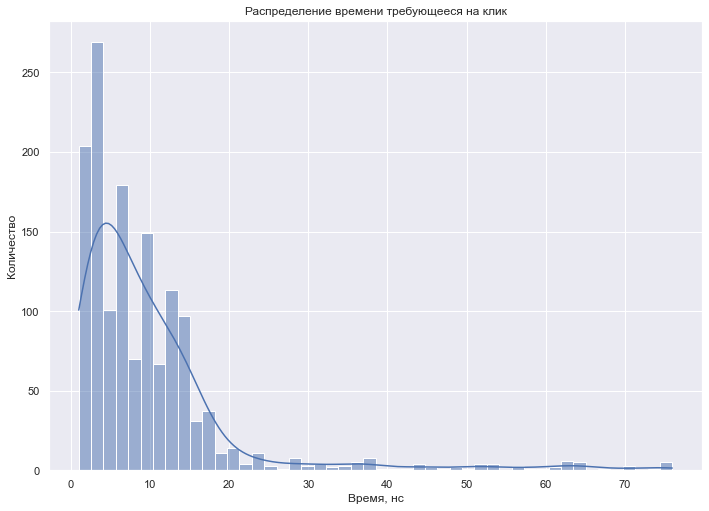

In [35]:
figure = sns.histplot(data=df_user_click[df_user_click['duration'] < 100], x='duration', kde=True)
plot_conf = figure.set(xlabel ='Время, нс', ylabel = 'Количество', title ='Распределение времени требующееся на клик')

В целом, если верно мое предположение, что время дано в наносекундах, то возможно уже можно сделать вывод, что количество кликов накручено. Большая часть кликов происходит менее чем за 20 c. Но тем не менее продолжу дальше исследовать данные.

Распределение очень похоже на экспоненциальное. Для удаления шумов я логарифмирую столбец (чтобы значения сместились к центру), затем, используя интерквартильный размах, определю шумы. 
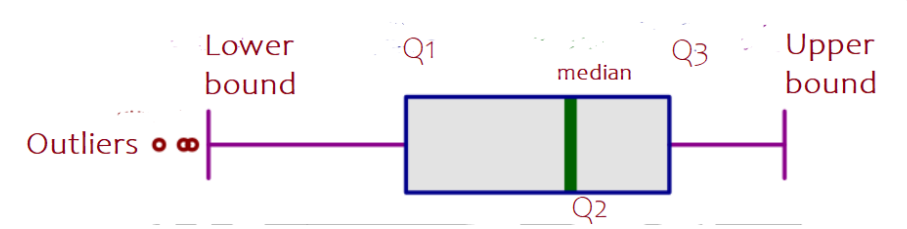

Удалено шумов 80


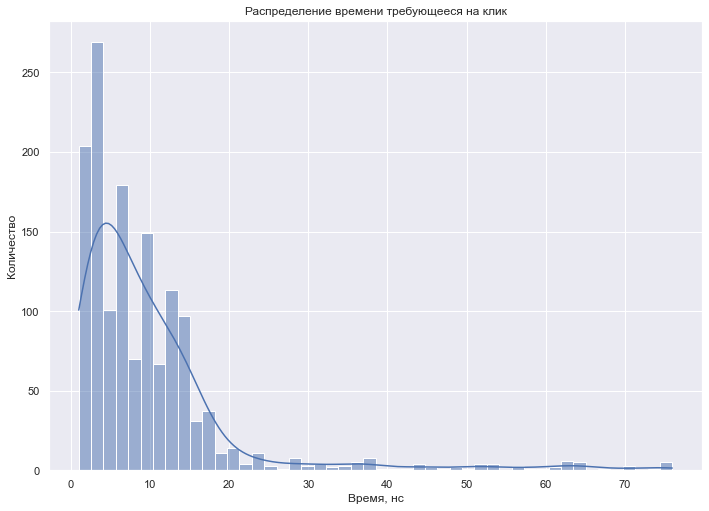

In [34]:
def tukey_noise(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]
    return df

df_user_click['log_duration'] = np.log(df_user_click['duration'].values)
df_user_click = tukey_noise(df_user_click, 'log_duration')
n_temp = df_user_click.shape[0]
print(f'Удалено шумов {n_init - n_temp}')

figure = sns.histplot(data=df_user_click, x="duration", kde=True)
# figure = sns.histplot(data=df_user_click, x='duration')
plot_conf = figure.set(xlabel='Время, нс', ylabel='Количество', 
                       title='Распределение времени требующееся на клик')

Посмотрим динамику количества кликов в каждый день. В столбце sum вычисляется кумулятивная сумма пользователей, которые кликнули. В столбце user количество пользователей в конкретный момент времени.

In [17]:
df_sort_by_time = df[df['tn'] == 1].sort_values(by=['t'], ascending=True, axis=0)

df_count_user = df_sort_by_time.groupby(by=['t'], as_index=False)['user'].count()
df_count_user['sum'] = df_count_user['user'].cumsum()
df_count_user['date'] = pd.to_datetime(df_count_user['t'])
# df_count_user.set_index('date', inplace=True)
df_count_user.head()

,t,user,sum,date
0,1480,1,1,1970-01-01 00:00:00.000001480
1,1532,1,2,1970-01-01 00:00:00.000001532
2,1716,1,3,1970-01-01 00:00:00.000001716
3,1844,1,4,1970-01-01 00:00:00.000001844
4,1912,1,5,1970-01-01 00:00:00.000001912


Так как в большинстве случаев на каждый момент времени приходится 1 пользователей, вычислим общее количество пользователей за period_ns.

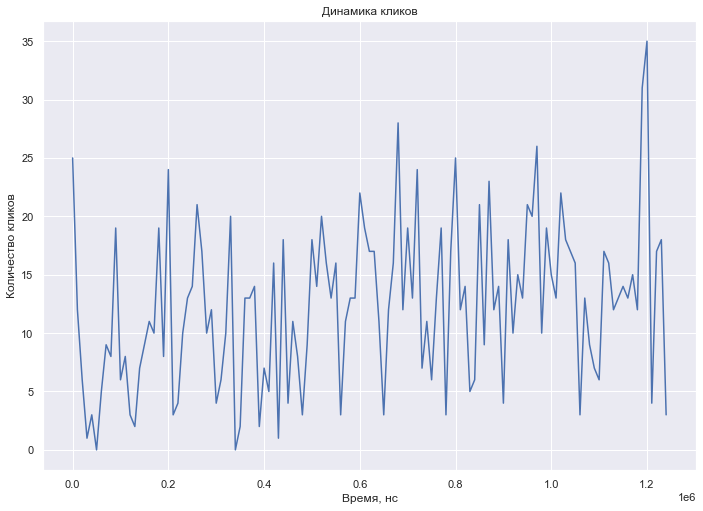

In [47]:
period_ns = 10000
df_grouped = df_count_user.groupby(pd.Grouper(key='date', freq=f'{period_ns}ns'))
df_avg = df_grouped['user'].sum()
df_avg = df_avg.to_frame()
df_avg['ts'] = df_avg.index.values.astype(np.int64)

figure = sns.lineplot(x='ts', y='user', data=df_avg)
plot_conf = figure.set(xlabel='Время, нс', ylabel='Количество кликов', 
                       title='Динамика кликов')